In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input

SEED=42
os.environ["PYTHONHASHSEED"]=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

gpus=tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2025-06-18 11:46:49.269666: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-18 11:46:49.761438: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-18 11:46:49.761560: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-18 11:46:49.846750: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-18 11:46:50.015536: I tensorflow/core/platform/cpu_feature_guar

In [2]:
IMG_SIZE=224
BATCH_SIZE=32
DATA_PATH="../../data/processed/04_kaggle_dataset"

# 조금 더 보수적으로
datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=3,
    zoom_range=0.05,
    brightness_range=[0.9, 1.1],
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode="nearest",
    validation_split=0.2
)

train_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=SEED
)

val_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    class_mode="binary",
    subset="validation",
    shuffle=False,
    seed=SEED
)

Found 8032 images belonging to 2 classes.
Found 2007 images belonging to 2 classes.


In [3]:
# 모델 정의
base_model=MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable=False

model=Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

MODEL_PATH="../../src/models/24_mobilenetv2_tuned/best_model.keras"
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
mcp=ModelCheckpoint(MODEL_PATH, monitor="val_loss", save_best_only=True, verbose=1)
es=EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
reducelr=ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)

2025-06-18 11:47:06.435379: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-18 11:47:06.435463: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-18 11:47:06.435502: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-18 11:47:06.645240: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-18 11:47:06.645312: I external/local_xla/xla/stream_executor

In [4]:
history=model.fit(train_generator, validation_data=val_generator,
                  epochs=20, callbacks=[mcp, es, reducelr], verbose=1)

Epoch 1/20


2025-06-18 11:47:09.393443: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-06-18 11:47:09.709096: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2025-06-18 11:47:09.709135: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2025-06-18 11:47:09.709196: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-06-18 11:47:10.447433: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-06-18 11:47:10.447479: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kerne

  1/251 [..............................] - ETA: 13:49 - loss: 0.7733 - accuracy: 0.6875

2025-06-18 11:47:11.145211: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa75c8ee550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-18 11:47:11.145247: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-06-18 11:47:11.163320: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-18 11:47:11.207630: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:408] Couldn't read CUDA driver version.
I0000 00:00:1750214831.216973    7590 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


251/251 [==============================] - ETA: 0s - loss: 0.4094 - accuracy: 0.8166
Epoch 1: val_loss improved from inf to 0.28562, saving model to ../../src/models/24_mobilenetv2_tuned/best_model.keras
251/251 [==============================] - 55s 205ms/step - loss: 0.4094 - accuracy: 0.8166 - val_loss: 0.2856 - val_accuracy: 0.8939 - lr: 1.0000e-04
Epoch 2/20
251/251 [==============================] - ETA: 0s - loss: 0.2615 - accuracy: 0.8987
Epoch 2: val_loss improved from 0.28562 to 0.22798, saving model to ../../src/models/24_mobilenetv2_tuned/best_model.keras
251/251 [==============================] - 48s 192ms/step - loss: 0.2615 - accuracy: 0.8987 - val_loss: 0.2280 - val_accuracy: 0.9133 - lr: 1.0000e-04
Epoch 3/20
251/251 [==============================] - ETA: 0s - loss: 0.2368 - accuracy: 0.9069
Epoch 3: val_loss improved from 0.22798 to 0.21273, saving model to ../../src/models/24_mobilenetv2_tuned/best_model.keras
251/251 [==============================] - 49s 194ms/ste

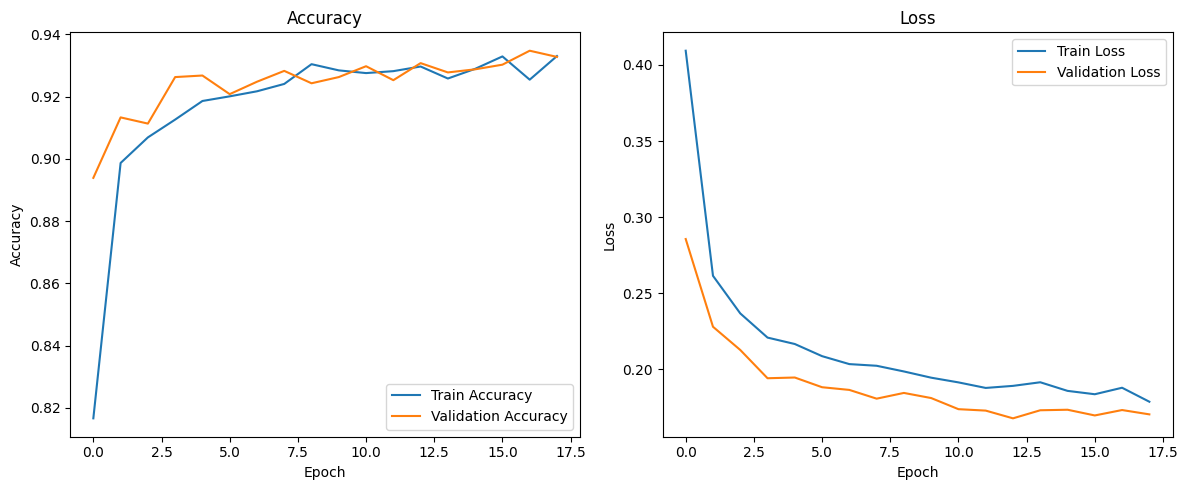

In [5]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig("../../results/images/24_mobilenetv2_training_plot.png")
plt.show()

=== Classification Report ===
              precision    recall  f1-score   support

      Closed       0.93      0.93      0.93      1000
      Opened       0.93      0.93      0.93      1007

    accuracy                           0.93      2007
   macro avg       0.93      0.93      0.93      2007
weighted avg       0.93      0.93      0.93      2007



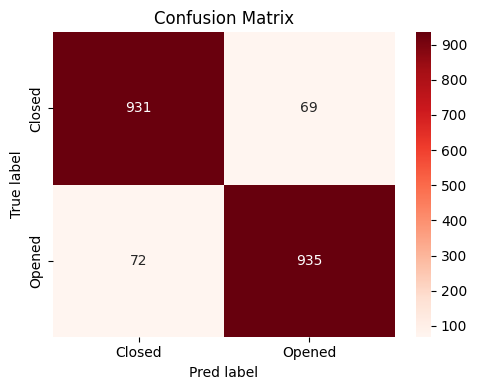

In [6]:
steps=val_generator.samples // val_generator.batch_size + 1
y_true=val_generator.classes
y_pred_prob=model.predict(val_generator, steps=steps, verbose=0)
y_pred=(y_pred_prob > 0.5).astype(int)

report=classification_report(y_true, y_pred, target_names=["Closed", "Opened"])
print("=== Classification Report ===")
print(report)

with open("../../results/reports/24_mobilenetv2_classification_report.txt", "w") as f:
    f.write(report)

conf_matrix=confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds",
            xticklabels=["Closed", "Opened"], yticklabels=["Closed", "Opened"])
plt.title("Confusion Matrix")
plt.xlabel("Pred label")
plt.ylabel("True label")
plt.tight_layout()
plt.savefig("../../results/images/24_mobilenetv2_confusion_matrix.png")
plt.show()

In [7]:
model.save("../../webcam_app/model/model_reexport.keras")

In [8]:
model.save("../../webcam_app/model/model_reexport.h5")

/home/julianjeong/miniconda3/envs/WSL_CUDA_TF01/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
